# Spectral Analysis

This example demonstrates how to perform 1-dimensional analysis using the `scipy.signal` module. To learn more about the functions and keyword arguments available in this package, read Scipy's [Signal Processing documentation](https://docs.scipy.org/doc/scipy/reference/signal.html).

The motivation for this example is to demonstrate how to perform the NCl function [`specx_anal()`](https://www.ncl.ucar.edu/Document/Functions/Built-in/specx_anal.shtml), which calculates the spectra of a series, in Python. Specifically, we are recreating the [`spec_1.ncl`](https://www.ncl.ucar.edu/Applications/Scripts/spec_1.ncl) NCL example in order to produce the same output spectrum (periodogram) of a 1-D dataset.

For more examples of use, look at [NCL spectral analysis applications](https://www.ncl.ucar.edu/Applications/spec.shtml).

To see a concise example using Python, visit the [spectral_analysis]() notebook.

According to the [NCL `specx_anal()` documentation](https://www.ncl.ucar.edu/Document/Functions/Built-in/specx_anal.shtml), the function:

1. Optionally detrends the series
2. Optionally tapers the series
3. Calculates the variance of the detrended/tapered series
4. Finds the Fast Fourier Transform of the series
5. Squares the Fourier coefficients (i.e. the periodogram)
6. Smooths the periodogram estimates 
7. Normalizes the periodogram so that the area under the curve matches the calculated variance

We will be able to combine steps 4 and 5 using `scipy.signal.periodogram()`.

In [2]:
import xarray as xr
import geocat.datafiles as gcd
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import numpy as np

## Performing the Periodogram

### Read in Data

We'll use the [`geocat-datafiles`](https://github.com/NCAR/geocat-datafiles) module to access the relevant datafile for this example: `SOI_Darwin.nc`

Then, we use [`Xarray.open_dataset()`](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) function to read the data as an xarray dataset.

This data represents the Darwin Southern Oscillation Index between 1882 and 1998 using normalized sea level pressure.

In [3]:
soi_darwin = xr.open_dataset(gcd.get('netcdf_files/SOI_Darwin.nc'))

soi_darwin

<xarray.Dataset> Size: 22kB
Dimensions:  (time: 1404)
Coordinates:
  * time     (time) int32 6kB 0 1 2 3 4 5 6 ... 1398 1399 1400 1401 1402 1403
Data variables:
    date     (time) float64 11kB ...
    DSOI     (time) float32 6kB ...
Attributes:
    title:          Darwin Southern Oscillation Index
    source:         Climate Analysis Section, NCAR
    history:        \nDSOI = - Normalized Darwin\nNormalized sea level pressu...
    creation_date:  Tue Mar 30 09:29:20 MST 1999
    references:     Trenberth, Mon. Wea. Rev: 2/1984
    time_span:      1882 - 1998
    conventions:    None

### Time Series Correction

Currently our `time` coordinate is in units of months since January 1882, we'll use `pandas` to change this to the conventional `DatetimeIndex`.

In [4]:
start_date = pd.Timestamp('1882-01-01')
dates = [start_date + pd.DateOffset(months=int(month)) for month in soi_darwin.indexes['time']]
datetime_index = pd.DatetimeIndex(dates)

datetime_index

DatetimeIndex(['1882-01-01', '1882-02-01', '1882-03-01', '1882-04-01',
               '1882-05-01', '1882-06-01', '1882-07-01', '1882-08-01',
               '1882-09-01', '1882-10-01',
               ...
               '1998-03-01', '1998-04-01', '1998-05-01', '1998-06-01',
               '1998-07-01', '1998-08-01', '1998-09-01', '1998-10-01',
               '1998-11-01', '1998-12-01'],
              dtype='datetime64[ns]', length=1404, freq=None)

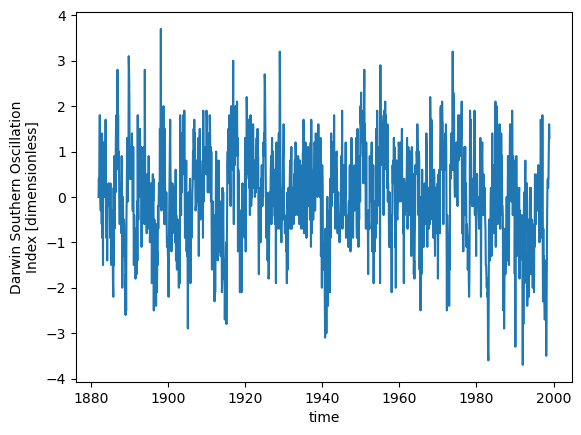

In [5]:
soi = soi_darwin.DSOI
soi['time'] = datetime_index

soi.plot()

### Detrend

Here we will do a simple detrending by removing the mean with [`scipy.signal.detrend()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html).

If you wanted to perform a linear least-squares fit, change `type='linear'`.

The `scipy.signal.periodogram()` function does have a detrending option, but because we are using an unsupported tapering window, and because detrending must be done before tapering, here we demonstrate how to separate out these steps.

In [6]:
soi_detrended = scipy.signal.detrend(soi, type='constant')

### Tapering

According to the code in [NCL's `taper.f`](https://github.com/NCAR/ncl/blob/edd46f5426286146313b31bd6826e3d3c360c0dc/ni/src/lib/nfpfort/taper.f), the tapering performed in the NCL example is split-cosine-bell tapering.

NCL also has a [`taper_n()`](https://www.ncl.ucar.edu/Document/Functions/Built-in/taper_n.shtml) function that is preferrable for performing tapering on specific dimensions, and is reported to be faster.

It is unclear which tapering function is used within the NCL spectral analysis functions.

Split-cosine-bell tapering is sometimes identified to as Tukey tapering, however Tukey can also refer to "cosine tapering".

Here we demonstrate how to perform a unique tapering window with [`scipy.signal.windows.tukey`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.tukey.html). Your desired tapering can be chosen instead.

In [7]:
percent_taper = 0.1
tukey_window = scipy.signal.windows.tukey(len(soi_detrended),
                                          alpha=percent_taper,
                                          sym = False) # generates a periodic window

soi_tapered = soi_detrended * tukey_window

### Periodogram

Now we can call [`scipy.signal.periodogram()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html).

A periodogram estimate is the square of the coefficients from the Fourier transform

There is also a `scaling` keyword that defaults to `density` for computing the power spectral density with units of $V^{2}/Hz$, with V being the units of the input array (here dimensionless), and `Hz` representing your frequency units (we'll use per month instead of per second). `spectral` is also supported and produces the squared magnitude spectrum with units of $V^{2}$.

In [8]:
freq_soi, psd_soi = scipy.signal.periodogram(soi_tapered, 
                                  fs=1, # sample monthly
                                  detrend=False)

### Smoothing

To provide statistical reliability, the periodogram estimates **must be smoothed**.

The NCL example uses modified Daniel kernel smoothing, which is not supported, here we'll demonstrate how to perform your own custom smoothing using [`scipy.signal.convolve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html).

Here is a [list of supported smoothing windows](https://docs.scipy.org/doc/scipy/reference/signal.windows.html).

In [9]:
k = 7 # define smoothing constant

kernel = np.ones(7) # Create a Daniel smoothing kernel
kernel[0] = 0.5 # "Modify" kernel by making the endpoints have half the weight of the interior points
kernel[-1] = 0.5
kernel = kernel / kernel.sum()

smoothed_psd = scipy.signal.convolve(psd_soi, kernel,
                                     mode='same') # Sets output array as the same length as the first input

### Normalization

Lastly we'll normalize our smoothed periodogram by the variance of the detrended and tapered series.

In [10]:
variance = np.var(soi_tapered, ddof=1)

df = freq_soi[1] - freq_soi[0] # Frequency step

# Create an array to adjust contributions of endpoints
frac = np.ones_like(freq_soi)
frac[0] = 0.5
frac[-1] = 0.5

current_area = np.sum(smoothed_psd * df * frac) # Calculate the current area under the curve
normalization_factor = variance / current_area # Find the factor to adjust this area

normalized_psd = smoothed_psd * normalization_factor # Apply the normalization factor to the smoothed power spectrum

### Plot

(0.0, 0.5)

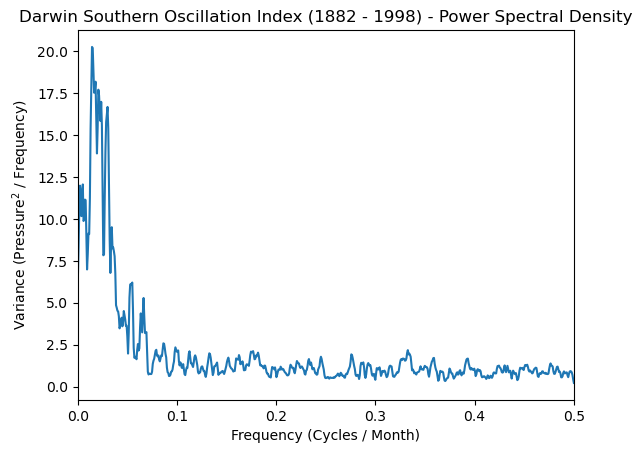

In [11]:
plt.plot(freq_soi, normalized_psd)
plt.xlabel('Frequency (Cycles / Month)')
plt.ylabel('Variance (Pressure$^2$ / Frequency)')
plt.title('Darwin Southern Oscillation Index (1882 - 1998) - Power Spectral Density')
plt.xlim([0,.5])

## Comparison to NCL Output

### Read in NCL output

We'll read in data from `spec_1.nc` data with and without tapering applied.

In [13]:
ncl = xr.open_dataset('spec_1_output.nc').spec
frq = ncl.frq
spcx = ncl.spcx

### Plot

We'll see that the plots are very similar, but with some differences at the lowest frequencies.

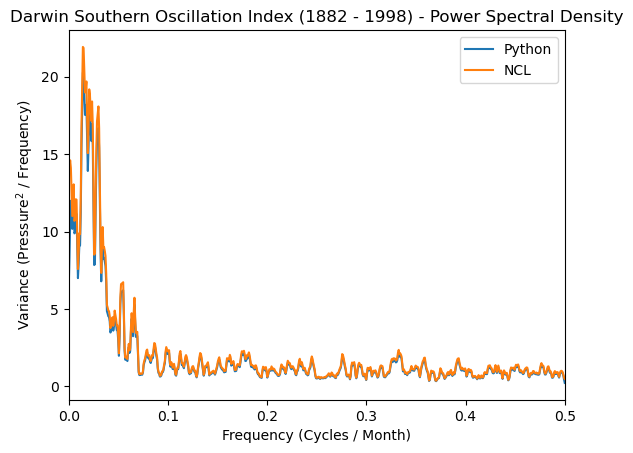

In [14]:
plt.plot(freq_soi, normalized_psd, label='Python')
plt.plot(frq, spcx, label='NCL')
plt.xlabel('Frequency (Cycles / Month)')
plt.ylabel('Variance (Pressure$^2$ / Frequency)')
plt.title('Darwin Southern Oscillation Index (1882 - 1998) - Power Spectral Density')
plt.xlim([0,.5])
plt.legend()

Text(0.5, 1.0, 'Python - NCL')

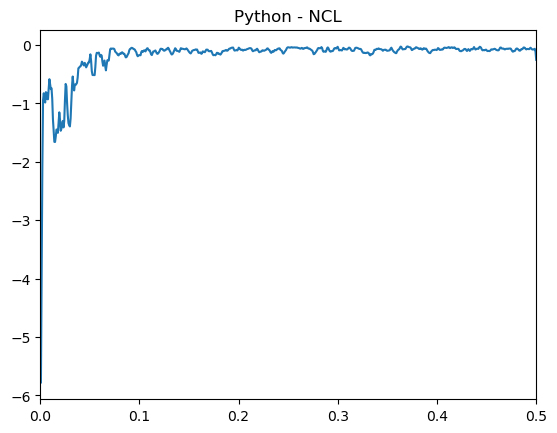

In [15]:
plt.plot(frq, normalized_psd[1:] - spcx)
plt.xlim([0,.5])
plt.title('Python - NCL')
plt.xlabel('Frequency (Cycles / Month)')

## Comparison without Tapering

It is important to remember that Periodograms are estimates of a spctra, and the math for performing this analysis, as well as for various window operations, have changed over the decades since NCL was written. 

We have demonstrated to the best of our ability how to follow the decisions made by the NCL funciton and have results similar enough to be confident that this approach in Python is correct. This is especially true considering that a scientist will be consciously making consistent tapering, smoothing, detrending, and normalization options regardless of platform.

However, in the interest of tracking down the differences we will investigate the output from Python and NCL without tapering.

Because Tukey tapering can refer to split-bell-cosine or cosine tapering, this is the step of our workflow where NCL's decisions are the least clear.

In [16]:
ncl_notaper = xr.open_dataset('spec_1_output_notaper.nc').spec
spcx_nt = ncl_notaper.spcx

In [17]:
# Compute Periodogram without tapering and with mean removed
freq_soi, psd_soi_nt = scipy.signal.periodogram(soi_detrended, 
                                  fs=1, # sample monthly
                                  detrend=False)
 
# Smooth with the same modified Daniel kernel as before
smoothed_psd_nt = scipy.signal.convolve(psd_soi_nt, kernel,
                                     mode='same')

# Normalize
variance = np.var(soi_detrended, ddof=1)
current_area = np.sum(smoothed_psd_nt * df * frac) # Calculate the current area under the curve
normalization_factor = variance / current_area # Find the factor to adjust this area

normalized_psd_nt = smoothed_psd_nt * normalization_factor # Apply the normalization factor to the smoothed power spectrum

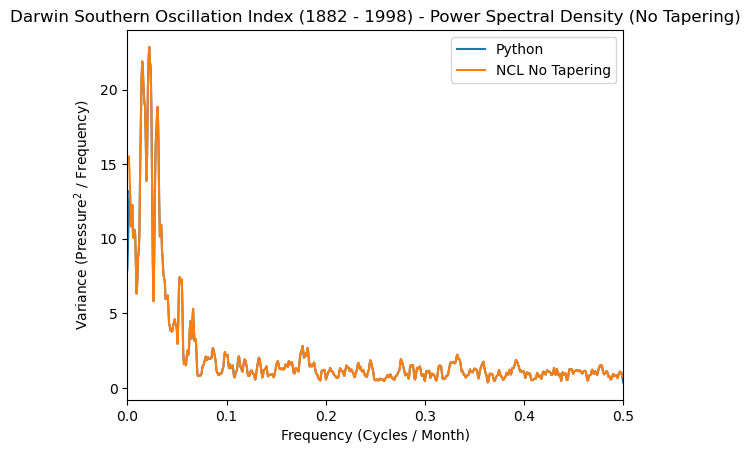

In [18]:
plt.plot(freq_soi, normalized_psd_nt, label='Python')
plt.plot(frq, spcx_nt, label='NCL No Tapering')
plt.xlabel('Frequency (Cycles / Month)')
plt.ylabel('Variance (Pressure$^2$ / Frequency)')
plt.title('Darwin Southern Oscillation Index (1882 - 1998) - Power Spectral Density (No Tapering)')
plt.xlim([0,.5])
plt.legend()

Text(0.5, 0, 'Frequency (Cycles / Month)')

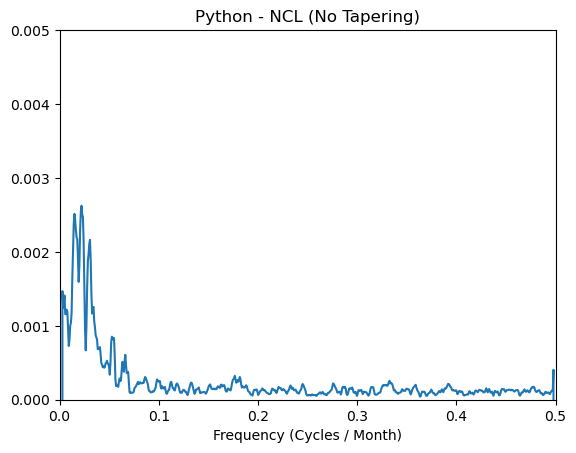

In [24]:
plt.plot(frq, normalized_psd_nt[1:] - spcx_nt)
plt.xlim([0,.5])
plt.title('Python - NCL (No Tapering)')
plt.ylim([-0.00,0.005])
plt.xlabel('Frequency (Cycles / Month)')

The remaining difference seems minimal, with an artifact at the smallest frequencies possibly due to more modernized ways of computing fourier transforms.